In [1]:
pip install vit-pytorch linformer

     |████████████████████████████████| 50 kB 2.8 MB/s 


## Importing the necessary packages 

In [2]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm   
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from linformer import Linformer   
import glob   
from itertools import chain   
from vit_pytorch.efficient import ViT   
from __future__ import print_function
from PIL import Image


In [4]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   

#to unzip the datasets
import zipfile

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
batch_size = 64
epochs = 50
lr = 3e-5
gamma = 0.7 #for learning rate scheduler

In [7]:
! pip install -q kaggle

## Uploading the .JSON API credentials. Downloaded from kaggle.


In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satwiksmishra","key":"f0ce50682a9fa8683091244dfe1a1280"}'}

In [9]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### If there is a 403 error, use this.

In [10]:
!pip install --upgrade --force-reinstall --no-deps kaggle


     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=7deef0b81522672f3c8f2888e324cd7f432d7bbf14a81d05d1c96fc4d4bc9f56
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [11]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 803M/814M [00:06<00:00, 79.6MB/s]
100% 814M/814M [00:06<00:00, 127MB/s] 


In [12]:
!kaggle -v

Kaggle API 1.5.12


In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("CUDA Available:", use_cuda)
print("Selected Device:", device)
seed = 1
# For reproducibility
torch.manual_seed(seed)

CUDA Available: True
Selected Device: cuda


## unzip the dataset

Don't forget to download the data in the drive and then go to the further steps.

In [14]:
!unzip /content/dogs-vs-cats-redux-kernels-edition.zip

Archive:  /content/dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


## organize the data.

In [15]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [16]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Have a look at the sample set here

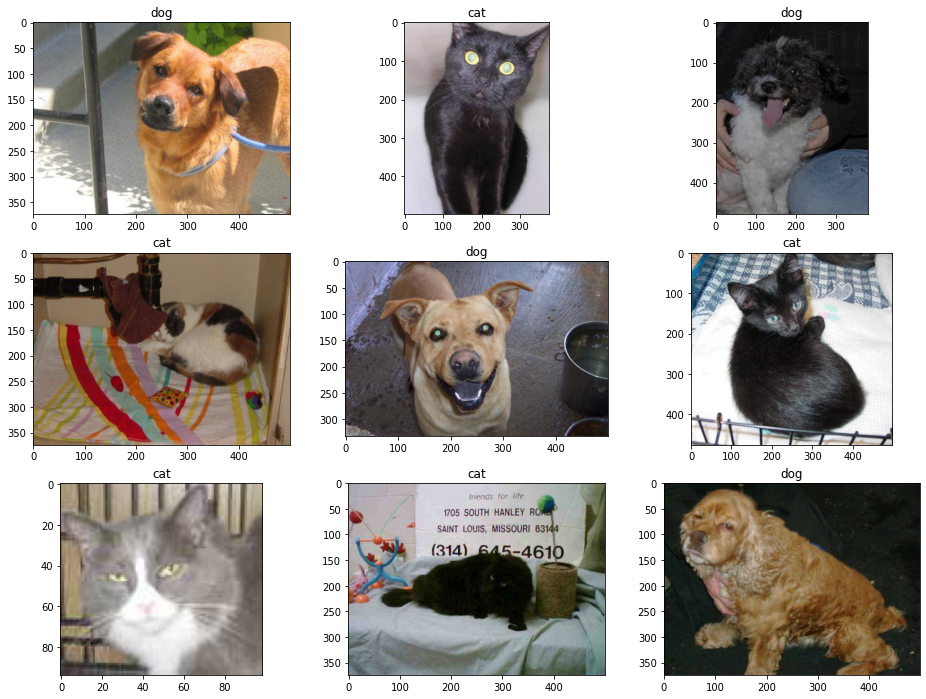

In [17]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Train, test split 

In [18]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Data transformation

In [19]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [20]:
class DogCatDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [21]:
train_data = DogCatDataset(train_list, transform=train_transforms)
valid_data = DogCatDataset(valid_list, transform=test_transforms)
test_data = DogCatDataset(test_list, transform=test_transforms)

In [22]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [23]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1, 
    depth=12,
    heads=8,
    k=64
)

In [24]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

## Training

In [25]:
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
optimizer = optim.Adam(model.parameters(), lr=lr)
history = [[0]*5]*epochs

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    history[epoch] = [epoch, epoch_loss.item(), epoch_accuracy.item(), epoch_val_loss.item(), epoch_val_accuracy.item()]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6953 - acc: 0.5078 - val_loss : 0.6915 - val_acc: 0.5095



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6910 - acc: 0.5249 - val_loss : 0.6920 - val_acc: 0.5293



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6861 - acc: 0.5466 - val_loss : 0.6842 - val_acc: 0.5346



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6799 - acc: 0.5641 - val_loss : 0.6710 - val_acc: 0.5908



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6744 - acc: 0.5767 - val_loss : 0.6688 - val_acc: 0.5807



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6654 - acc: 0.5879 - val_loss : 0.6507 - val_acc: 0.6125



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6532 - acc: 0.6050 - val_loss : 0.6486 - val_acc: 0.6151



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6450 - acc: 0.6191 - val_loss : 0.6399 - val_acc: 0.6177



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6422 - acc: 0.6211 - val_loss : 0.6276 - val_acc: 0.6335



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6349 - acc: 0.6320 - val_loss : 0.6249 - val_acc: 0.6377



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6272 - acc: 0.6390 - val_loss : 0.6221 - val_acc: 0.6454



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6225 - acc: 0.6443 - val_loss : 0.6014 - val_acc: 0.6610



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6154 - acc: 0.6533 - val_loss : 0.5974 - val_acc: 0.6776



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6140 - acc: 0.6556 - val_loss : 0.5938 - val_acc: 0.6770



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6085 - acc: 0.6599 - val_loss : 0.5988 - val_acc: 0.6703



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6007 - acc: 0.6686 - val_loss : 0.5861 - val_acc: 0.6806



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5976 - acc: 0.6712 - val_loss : 0.5897 - val_acc: 0.6863



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5934 - acc: 0.6785 - val_loss : 0.5839 - val_acc: 0.6897



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5910 - acc: 0.6760 - val_loss : 0.5783 - val_acc: 0.6893



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5871 - acc: 0.6840 - val_loss : 0.5785 - val_acc: 0.6879



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5863 - acc: 0.6879 - val_loss : 0.5632 - val_acc: 0.7091



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5811 - acc: 0.6832 - val_loss : 0.5730 - val_acc: 0.6936



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5851 - acc: 0.6891 - val_loss : 0.5744 - val_acc: 0.7009



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5785 - acc: 0.6946 - val_loss : 0.5681 - val_acc: 0.6964



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5783 - acc: 0.6929 - val_loss : 0.5621 - val_acc: 0.7043



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.5788 - acc: 0.6910 - val_loss : 0.5589 - val_acc: 0.7002



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5747 - acc: 0.6963 - val_loss : 0.5620 - val_acc: 0.6994



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5735 - acc: 0.6962 - val_loss : 0.5674 - val_acc: 0.7027



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5712 - acc: 0.6984 - val_loss : 0.5603 - val_acc: 0.7085



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5728 - acc: 0.6949 - val_loss : 0.5640 - val_acc: 0.6998



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5708 - acc: 0.6994 - val_loss : 0.5474 - val_acc: 0.7233



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.5695 - acc: 0.6999 - val_loss : 0.5670 - val_acc: 0.6944



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5639 - acc: 0.7049 - val_loss : 0.5574 - val_acc: 0.7023



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5645 - acc: 0.7028 - val_loss : 0.5565 - val_acc: 0.7075



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5682 - acc: 0.7012 - val_loss : 0.5544 - val_acc: 0.7144



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5635 - acc: 0.7042 - val_loss : 0.5542 - val_acc: 0.7142



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5575 - acc: 0.7089 - val_loss : 0.5429 - val_acc: 0.7160



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.5626 - acc: 0.7104 - val_loss : 0.5507 - val_acc: 0.7182



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5571 - acc: 0.7117 - val_loss : 0.5550 - val_acc: 0.7164



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5597 - acc: 0.7089 - val_loss : 0.5458 - val_acc: 0.7205



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5602 - acc: 0.7061 - val_loss : 0.5474 - val_acc: 0.7188



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5541 - acc: 0.7127 - val_loss : 0.5412 - val_acc: 0.7263



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5583 - acc: 0.7110 - val_loss : 0.5500 - val_acc: 0.7164



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5574 - acc: 0.7128 - val_loss : 0.5464 - val_acc: 0.7217



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5525 - acc: 0.7119 - val_loss : 0.5494 - val_acc: 0.7120



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5517 - acc: 0.7136 - val_loss : 0.5469 - val_acc: 0.7097



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5510 - acc: 0.7165 - val_loss : 0.5485 - val_acc: 0.7225



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5462 - acc: 0.7196 - val_loss : 0.5431 - val_acc: 0.7201



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5519 - acc: 0.7161 - val_loss : 0.5403 - val_acc: 0.7231



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5508 - acc: 0.7142 - val_loss : 0.5352 - val_acc: 0.7235



In [26]:
his = history

In [27]:
for r in range(len(history)):
    for c in range(len(history[0])):
        if type(history[r][c]) == torch.Tensor:
            history[r][c] = history[r][c].item()

In [28]:
history = np.array(history).transpose(1,0)

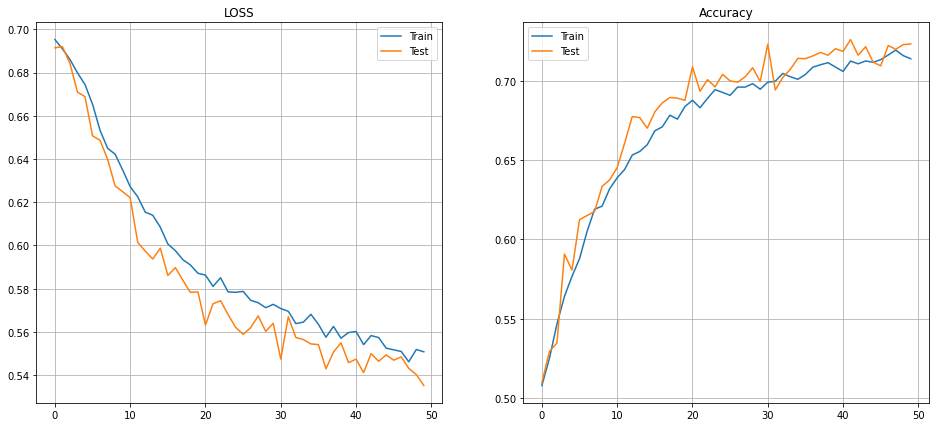

In [29]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[2], label='Train')
axs[1].plot(history[4], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [30]:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Saving the model to drive 

In [32]:
torch.save(model.state_dict(),"model.pt")

### Two classes

In [33]:
classes = ['cat', 'dog']

## Unzip the data for test

In [35]:
!unzip /content/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            

## Testing for a few images

## Links referred: 

https://github.com/lucidrains/vit-pytorch

https://issueexplorer.com/issue/lucidrains/vit-pytorch/113

Text(0.5, 1.0, 'Pred label: dog')

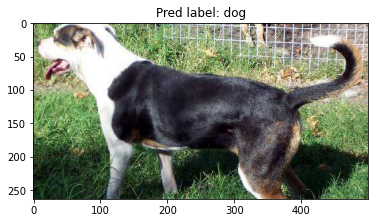

In [36]:
img1 = Image.open("/content/test/10003.jpg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

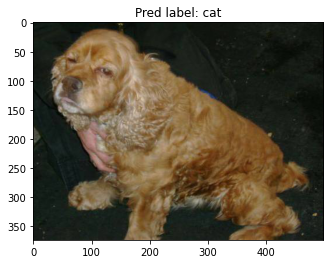

In [37]:
img1 = Image.open("/content/test/1001.jpg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

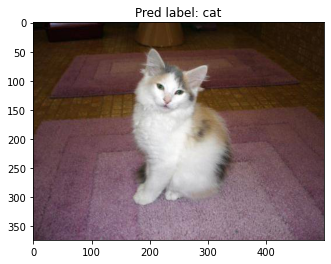

In [41]:
img1 = Image.open("/content/test/10.jpg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")